## 🤗 Finetune **Longformer Encoder-Decoder (LED)** on 8K Tokens 🤗

The *Longformer Encoder-Decoder (LED)* was recently added as an extension to [Longformer: The Long-Document Transformer](https://arxiv.org/abs/2004.05150) by Iz Beltagy, Matthew E. Peters, Arman Cohan.

In this notebook we will finetune *LED* for Summarization on [Pubmed](https://huggingface.co/datasets/viewer/?dataset=scientific_papers). *Pubmed* is a long-range summarization dataset, which makes it a good candidate for LED. LED will be finetuned up to an input length of 8K tokens on a single GPU.

We will leverage 🤗`Seq2SeqTrainer`, gradient checkpointing and as usual 🤗`datasets`.

First, let's try to get a GPU with at least 15GB RAM.

In [1]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  2 10:47:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# crash colab to get more RAM
# !kill -9 -1

To check that we are having enough RAM we can run the following command.
If the randomely allocated GPU is too small, the above cells can be run 
to crash the notebook hoping to get a better GPU.

In [4]:
!nvidia-smi

Thu Dec  2 10:47:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next, we install 🤗Transformers, 🤗Datasets, and `rouge_score`.



In [5]:
%%capture
!pip install datasets==1.2.1
!pip install transformers==4.2.0
!pip install rouge_score

Let's start by loading and preprocessing the dataset.



In [6]:
from datasets import load_dataset, load_metric

Next, we download the pubmed train and validation dataset ([click to see on 🤗Datasets Hub](https://huggingface.co/datasets/scientific_papers)). This can take a couple of minutes **☕** .

In [8]:
train_dataset = load_dataset("scientific_papers", "pubmed", split="train")

Reusing dataset scientific_papers (/root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/043e40ed208b8a66ee9e8228c86874946c99d2fc6155a1daee685795851cfdfc)


In [9]:
train_dataset[0]

{'abstract': " background : the present study was carried out to assess the effects of community nutrition intervention based on advocacy approach on malnutrition status among school - aged children in shiraz , iran.materials and methods : this case - control nutritional intervention has been done between 2008 and 2009 on 2897 primary and secondary school boys and girls ( 7 - 13 years old ) based on advocacy approach in shiraz , iran . \n the project provided nutritious snacks in public schools over a 2-year period along with advocacy oriented actions in order to implement and promote nutritional intervention . for evaluation of effectiveness of the intervention growth monitoring indices of pre- and post - intervention were statistically compared.results:the frequency of subjects with body mass index lower than 5% decreased significantly after intervention among girls ( p = 0.02 ) . \n however , there were no significant changes among boys or total population . \n the mean of all anthr

In [10]:
val_dataset = load_dataset("scientific_papers", "pubmed", split="validation")

Reusing dataset scientific_papers (/root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/043e40ed208b8a66ee9e8228c86874946c99d2fc6155a1daee685795851cfdfc)


In [11]:
val_dataset[0]

{'abstract': ' background and aim : there is lack of substantial indian data on venous thromboembolism ( vte ) . \n the aim of this study was to provide real - world information on patient characteristics , management strategies , clinical outcomes , and temporal trends in vte.subjects and methods : multicentre retrospective registry involving 549 medical records of patients with confirmed diagnosis of vte ( deep vein thrombosis [ dvt ] confirmed by doppler ultrasonography ; pulmonary embolism [ pe ] by computed tomography , pulmonary angiography and/or v / q scan ) from 2006 to 2010 at three indian tertiary care hospitals.results:acute dvt without pe , acute dvt with pe , and pe alone were reported in 64% ( 352/549 ) , 23% ( 124/549 ) , and 13% ( 73/549 ) patients , respectively . \n mean age was 47 ( 16 ) years , and 70% were males . \n h / o dvt ( 34% ) , surgery including orthopedic surgery ( 28% ) , trauma ( 16% ) , and immobilization > 3 days ( 14% ) were the most common risk fac

It's always a good idea to take a look at some data samples. Let's do that here.

In [12]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=4):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

We can see that the input data is the `article` - a scientific report and the target data is the `abstract` - a concise summary of the report.

Cool! Having downloaded the dataset, let's tokenize it.
We'll import the convenient `AutoTokenizer` class.

In [13]:
from transformers import AutoTokenizer

 and load the tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Note that for the sake of this notebook, we finetune the "smaller" LED checkpoint ["allenai/led-base-16384"](https://huggingface.co/allenai/led-base-16384). Better performance can however be attained by finetuning ["allenai/led-large-16384"](https://huggingface.co/allenai/led-large-16384) at the cost of a higher required GPU RAM.

Pubmed's input data has a median token length of 2715 with the 90%-ile token length being 6101. The output data has a media token length of 171 with the 90%-ile token length being 352.${}^1$. 

Thus, we set the maximum input length to 8192 and the maximum output length to 512 to ensure that the model can attend to almost all input tokens is able to generate up to a large enough number of output tokens.

In this notebook, we are only able to train on `batch_size=2` to prevent out-of-memory errors.

---
${}^1$ The data is taken from page 11 of [Big Bird: Transformers for Longer Sequences](https://arxiv.org/pdf/2007.14062.pdf).


In [15]:
max_input_length = 8192
max_output_length = 512
batch_size = 1

Now, let's write down the input data processing function that will be used to map each data sample to the correct model format.
As explained earlier `article` represents here our input data and `abstract` is the target data. The datasamples are thus tokenized up to the respective maximum lengths of 8192 and 512.

In addition to the usual `attention_mask`, LED can make use of an additional `global_attention_mask` defining which input tokens are attended globally and which are attended only locally, just as it's the case of [Longformer](https://huggingface.co/transformers/model_doc/longformer.html). For more information on Longformer's self-attention, please take a look at the corresponding [docs](https://huggingface.co/transformers/model_doc/longformer.html#longformer-self-attention). For summarization, we follow recommendations of the [paper](https://arxiv.org/abs/2004.05150) and use global attention only for the very first token. Finally, we make sure that no loss is computed on padded tokens by setting their index to `-100`.

In [16]:
def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["article"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["abstract"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

For the sake of this notebook, we will reduce the training and validation data 
to a dummy dataset of sizes 250 and 25 respectively. For a full training run, those lines should be commented out.

In [17]:
train_dataset = train_dataset.select(range(250))
val_dataset = val_dataset.select(range(25))

Great, having defined the mapping function, let's preprocess the training data

In [18]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "abstract", "section_names"],
)

and validation data

In [19]:
val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "abstract", "section_names"],
)

In [20]:
train_dataset[0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

**train_dataset**  
attention mask  
global_attention_mask  
input_ids  
labels

Finally, the datasets should be converted into the PyTorch format as follows.

In [21]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [22]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'global_attention_mask': tensor([1, 0, 0,  ..., 0, 0, 0]),
 'input_ids': tensor([  0, 102, 485,  ...,   1,   1,   1]),
 'labels': tensor([    0,  3618,  4832,     5,  1455,   892,    21,  2584,    66,     7,
          7118,     5,  3038,     9,   435, 10894,  6530,   716,    15,  8973,
          1548,    15, 29638,  2194,   566,   334,   111,  5180,   408,    11,
          1481,   853,  1222,  2156, 10209,   260,     4, 36739,    29,     8,
          6448,  4832,    42,   403,   111,   797, 22813,  6530,    34,    57,
           626,   227,  2266,     8,  2338,    15,   971,  6750,  2270,     8,
          5929,   334,  2786,     8,  1972,    36,   262,   111,   508,   107,
           793,  4839,   716,    15,  8973,  1548,    11,  1481,   853,  1222,
          2156, 10209,   260,   479,  1437, 50118,     5,   695,  1286, 30426,
         14967,    11,   285,  1304,    81,    10,   132,    12,   180,   675,
           552,    19,  897

Alright, we're almost ready to start training. Let's load the model via the `AutoModelForSeq2SeqLM` class.

In [21]:
from transformers import AutoModelForSeq2SeqLM

We've decided to stick to the smaller model `"allenai/led-base-16384"` for the sake of this notebook. In addition, we directly enable gradient checkpointing and disable the caching mechanism to save memory.

In [22]:
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

During training, we want to evaluate the model on Rouge, the most common metric used in summarization, to make sure the model is indeed improving during training. For this, we set fitting generation parameters. We'll use beam search with a small beam of just 2 to save memory. Also, we force the model to generate at least 100 tokens, but no more than 512. In addition, some other generation parameters are set that have been found helpful for generation. For more information on those parameters, please take a look at the [docs](https://huggingface.co/transformers/main_classes/model.html?highlight=generate#transformers.generation_utils.GenerationMixin.generate).

In [23]:
# set generate hyperparameters
led.config.num_beams = 2
led.config.max_length = 512
led.config.min_length = 100
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

Next, we also have to define the function the will compute the `"rouge"` score during evalution.

Let's load the `"rouge"` metric from 🤗datasets and define the `compute_metrics(...)` function.

In [24]:
rouge = load_metric("rouge")

The compute metrics function expects the generation output, called `pred.predictions` as well as the gold label, called `pred.label_ids`.

Those tokens are decoded and consequently, the rouge score can be computed.

In [25]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

Now, we're ready to start training. Let's import the `Seq2SeqTrainer` and `Seq2SeqTrainingArguments`.

In [26]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In contrast to the usual `Trainer`, the `Seq2SeqTrainer` makes it possible to use the `generate()` function during evaluation. This should be enabled with `predict_with_generate=True`. Because our GPU RAM is limited, we make use of gradient accumulation by setting `gradient_accumulation_steps=4` to have an effective `batch_size` of 2 * 4 = 8.

Other training arguments can be read upon in the [docs](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainingarguments#transformers.TrainingArguments).

In [27]:
# # enable fp16 apex training
# training_args = Seq2SeqTrainingArguments(
#     predict_with_generate=True,
#     evaluation_strategy="steps",
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     fp16=True,
#     output_dir="./",
#     logging_steps=5,
#     eval_steps=10,
#     save_steps=10,
#     save_total_limit=2,
#     gradient_accumulation_steps=4, ## 줄일 수 있는 parameter인듯. default=4
#     num_train_epochs=1,
# )

The training arguments, along with the model, tokenizer, datasets and the `compute_metrics` function can then be passed to the `Seq2SeqTrainer`

In [28]:
# trainer = Seq2SeqTrainer(
#     model=led,
#     tokenizer=tokenizer,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
# )

and we can start training. This will take about ~35min.

In [29]:
# ! pip install apex

     |████████████████████████████████| 75 kB 3.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 709 kB 16.9 MB/s 
     |████████████████████████████████| 246 kB 71.6 MB/s 
     |████████████████████████████████| 136 kB 62.8 MB/s 
     |████████████████████████████████| 114 kB 77.2 MB/s 
     |████████████████████████████████| 251 kB 80.6 MB/s 
     |████████████████████████████████| 133 kB 67.2 MB/s 
     |████████████████████████████████| 41 kB 46 kB/s 
     |████████████████████████████████| 47 kB 5.8 MB/s 
  Created wheel for apex: filename=apex-0.9.10.dev0-py3-none-any.whl size=46466 sha256=e0878b4b718bd898bec0514927b97c5129f4c3cb56ddbfe6b63907cbc20c50b2
  Stored in directory: /root/.cache/pip/wheels/f0/00/2b/37b6028388b451bbd30230c62f5238aef3b11fdff9503138bc
  Created wheel for velruse: filename=velruse-1.1.1-py3-none-any.whl size=50937 sha256=b4a228300e9d4

In [30]:
# trainer.train()

This completes the fine-tuning tutorial for LED. This training script with some small changes was used to train [this](https://huggingface.co/patrickvonplaten/led-large-16384-pubmed) checkpoint, called `" patrickvonplaten/led-large-16384-pubmed"` on a single GPU for ca. 3 days. Evaluating `" patrickvonplaten/led-large-16384-pubmed"` on Pubmed's test data gives a Rouge-2 score of **19.33** which is around 1 Rouge-2 point below SOTA performance on Pubmed.

In the Appendix below, the condensed training and evaluation scripts that were used locally to finetune `" patrickvonplaten/led-large-16384-pubmed"` are attached.

# **Appendix**

## Training

In [31]:
# ! pip3 install amp-atomistics

In [38]:
# # 시간 오래 걸림. 30분 정도 apex나 amp 사용 안하면 설치할 필요 없음

# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .

Cloning into 'apex'...
remote: Enumerating objects: 8639, done.
remote: Counting objects: 100% (726/726), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 8639 (delta 430), reused 471 (delta 264), pack-reused 7913
Receiving objects: 100% (8639/8639), 14.46 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (5829/5829), done.
/content/apex
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/loc

In [32]:
# import amp
# from apex import amp

In [61]:
#!/usr/bin/env python3
from datasets import load_dataset, load_metric
from transformers import (
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)

# load rouge
rouge = load_metric("rouge")

# load pubmed
pubmed_train = load_dataset("scientific_papers", "pubmed", ignore_verifications=True, split="train")
pubmed_val = load_dataset("scientific_papers", "pubmed", ignore_verifications=True, split="validation[:10%]")

# comment out following lines for a test run
# pubmed_train = pubmed_train.select(range(32))
# pubmed_val = pubmed_val.select(range(32))

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-large-16384")


# max encoder length is 8192 for PubMed
encoder_max_length = 8192
decoder_max_length = 512
batch_size = 1


def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["article"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
    )
    outputs = tokenizer(
        batch["abstract"],
        padding="max_length",
        truncation=True,
        max_length=decoder_max_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch


# map train data
pubmed_train = pubmed_train.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "abstract", "section_names"],
)

# map val data
pubmed_val = pubmed_val.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "abstract", "section_names"],
)

# set Python list to PyTorch tensor
pubmed_train.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

# set Python list to PyTorch tensor
pubmed_val.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

# enable fp16 apex training  ## ## name 'amp' is not defined 문제로 주석처리
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=False, ## default = True
    fp16_backend="auto", ## default = apex
    output_dir="./",
    logging_steps=250,
    eval_steps=5000,
    save_steps=500,
    warmup_steps=1500,
    save_total_limit=2,
    gradient_accumulation_steps=4,
)


# compute Rouge score during validation
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


# load model + enable gradient checkpointing & disable cache for checkpointing
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# set generate hyperparameters
led.config.num_beams = 4
led.config.max_length = 512
led.config.min_length = 100
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3


# instantiate trainer
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args, ## optional
    compute_metrics=compute_metrics,
    train_dataset=pubmed_train,
    eval_dataset=pubmed_val,
)

# start training
trainer.train()

Reusing dataset scientific_papers (/root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/043e40ed208b8a66ee9e8228c86874946c99d2fc6155a1daee685795851cfdfc)
Reusing dataset scientific_papers (/root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/043e40ed208b8a66ee9e8228c86874946c99d2fc6155a1daee685795851cfdfc)
Loading cached processed dataset at /root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/043e40ed208b8a66ee9e8228c86874946c99d2fc6155a1daee685795851cfdfc/cache-d5e11f198483e4b7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/043e40ed208b8a66ee9e8228c86874946c99d2fc6155a1daee685795851cfdfc/cache-8776a54252755b17.arrow


RuntimeError: ignored

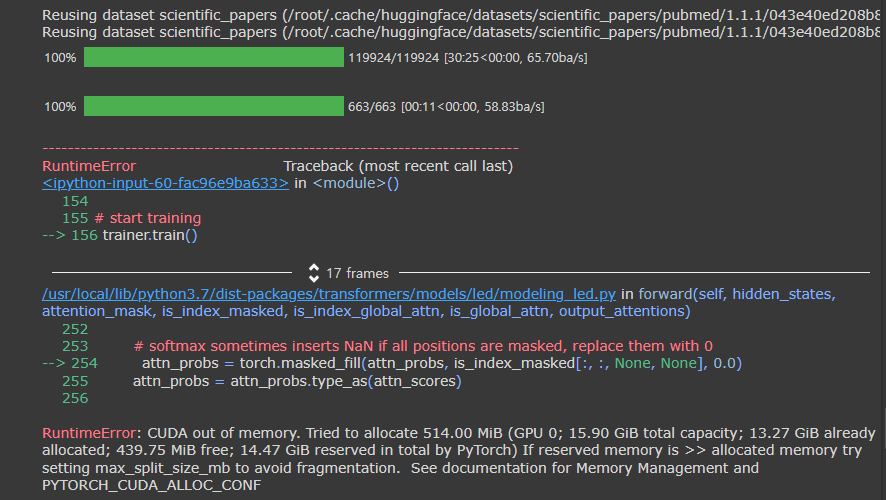

## Evaluation

In [ ]:
import torch

from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

# load pubmed
pubmed_test = load_dataset("scientific_papers", "pubmed", ignore_verifications=True, split="test")

# load tokenizer
tokenizer = LEDTokenizer.from_pretrained("patrickvonplaten/led-large-16384-pubmed")
model = LEDForConditionalGeneration.from_pretrained("patrickvonplaten/led-large-16384-pubmed").to("cuda").half()


def generate_answer(batch):
  inputs_dict = tokenizer(batch["article"], padding="max_length", max_length=8192, return_tensors="pt", truncation=True)
  input_ids = inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)
  # put global attention on <s> token
  global_attention_mask[:, 0] = 1

  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch["predicted_abstract"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch


result = pubmed_test.map(generate_answer, batched=True, batch_size=1)

# load rouge
rouge = load_metric("rouge")

print("Result:", rouge.compute(predictions=result["predicted_abstract"], references=result["abstract"], rouge_types=["rouge2"])["rouge2"].mid)


Out Of Memory 문제가 발생해서 GCP 상에서 다시 돌려봐야겠다.